In [18]:
# import the required libraries
import pandas as pd
import numpy as np
import copy
from IPython.display import clear_output
import warnings
from re import sub
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm import tqdm

In [19]:
#Load The news dataset
data = pd.read_csv('~/cloudfiles/code/Users/walidtarrab/MINDsmall_train/news.tsv',header=None, delimiter='\t')
data.columns=['News-ID',
"Category",
"SubCategory",
"Title",
"Abstract",
"URL",
"Title Entities",
"Abstract Entities "]

In [20]:
data.shape

(51282, 8)

In [21]:
value_category = data[['Category','SubCategory']].value_counts()   #Here we are counting the combinations category x with subcategory y

In [22]:
index =[]
for i in value_category.index:
  index.append(np.array(i))

index = np.array(index)

In [23]:
df_values_and_cat = pd.DataFrame(columns=['Category','SubCategory','Values'])
df_values_and_cat['Category'] = index[:,0]     #Gets all categories
df_values_and_cat['SubCategory'] = index[:,1]   #Gets all the subcategories
df_values_and_cat['Values'] = value_category.values  #Gets all the values for the combo [category,subcategory]

In [24]:
px.bar(data_frame=df_values_and_cat,x='Category',y='Values',color='SubCategory') #This plots the quantity of times one category appears in our dataset in y and the category in x.
#Remember that we got values for our combo ['category','subcategory'] therefore seting color ='subcategory', actually is ploting that number of combos above the values plot.
#In other words we got a full count of times "News" appeared, then we got the colors showing how many times "news" was paired with "newsus","football_nfl" and so on.

After the data was imported, we looked at the distribution of the categories and
subcategories of the news. Most of the news originated in the USA, which means that the model
should be more representative of the US market.

In [25]:
t=[]
for i in data['Title']:
    t.append(len(i))
px.histogram(t,color=data['Category'])

Most news titles' lengths are at the 60 words mark, with most of them falling between 50-100.
Some of the news have very short titles making the process of extracting any useful information
out of them impractical. These articles will be removed in the preprocessing step.

In [26]:
#Do some data cleaning
data.dropna(inplace=True)
print('the number of articles before processing :',len(data))
data.drop_duplicates(subset=['Title'],inplace=True)
print('The number of articles after processing :',len(data))
#the number of articles before processing : 48616
#The number of articles after processing : 47799
print('the number of articles before processing :',len(data))
data=data[data['Title'].apply((lambda x: len(x.split())>=4))]
print('The number of articles after processing :',len(data))
#the number of articles before processing : 47799
#The number of articles after processing : 47672

the number of articles before processing : 48612
The number of articles after processing : 47795
the number of articles before processing : 47795
The number of articles after processing : 47668


In [27]:
data['News-ID'].fillna('N/A', inplace=True)

In [28]:
#Load the dataset with the users and their behaviors

user_info= pd.read_csv('~/cloudfiles/code/Users/walidtarrab/MINDsmall_train/behaviors.tsv',header=None, delimiter='\t')
user_info.dropna()


#Get the unique users in the dataset
user_info.columns=["Impression-ID","User-ID","Impression Time","User Click History", "Impression News"]
users_id = user_info['User-ID'].unique()

In [29]:
#This function "finds" the user complete information given his ID
def find_info(user_id,user_info):
  user = user_info.loc[user_info['User-ID']==user_id]

  return user

from tqdm import tqdm
def get_most_clicked(users_id,user_info):
  all_click_history = []
  for user_id in tqdm(users_id):

    user = user_info.loc[user_info['User-ID']==user_id]
    user_history = user['User Click History']

    all_click_history.append(user_history.values)

  all_click_history = np.array(all_click_history).flatten()

  news_id_counts = pd.Series(all_click_history).value_counts()
  top_news_ids = news_id_counts.head(10000)

  return list(top_news_ids)


def get_news_titles(news_id,data):
  titles = []
  for news in tqdm(news_id):
    title = data[data['News-Id']==news]['Title'].values
    titles.append(title)

  return titles

In [30]:
news_titles = data['Title']

In [31]:
!pip install transformers -q
!pip install torch -q

In [32]:
# tokenize the news' titles
import torch
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer, DistilBertModel

# Load pre-trained DistilBERT model and tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertModel.from_pretrained(model_name)


# Set the device to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Tokenize news titles
tokenized_inputs = tokenizer(
    list(news_titles), padding=True, truncation=True, return_tensors='pt')
input_ids = tokenized_inputs['input_ids']
attention_mask = tokenized_inputs['attention_mask']
num_samples = len(news_titles) 
batch_size = 1

# Embed news titles
with torch.no_grad():
    model.to(device)
    model.eval()

    # Embed news titles in batches
    embeddings = []
    for i in range(0, num_samples, batch_size):
        inputs_batch = {
            'input_ids': input_ids[i:i+batch_size].to(device),
            'attention_mask': attention_mask[i:i+batch_size].to(device)
        }

        # Get the BERT embeddings
        outputs = model(**inputs_batch)

        # Extract the last layer's hidden states
        batch_embeddings =  outputs.last_hidden_state.cpu().numpy()
        embeddings.append(batch_embeddings)

# Concatenate embeddings from all batches
embeddings = np.concatenate(embeddings, axis=0)

# Create a DataFrame to store embeddings and titles
df_embeddings = pd.DataFrame(
    {'News-ID': data['News-ID'].loc[:num_samples], 'Title': news_titles[:num_samples], 'Embedding': embeddings.tolist()})

# Print the DataFrame
print(df_embeddings)



/home/guest/anaconda3/envs/egg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


      News-ID                                              Title  \
0      N55528  The Brands Queen Elizabeth, Prince Charles, an...   
1      N19639                      50 Worst Habits For Belly Fat   
2      N61837  The Cost of Trump's Aid Freeze in the Trenches...   
3      N53526  I Was An NBA Wife. Here's How It Affected My M...   
4      N38324  How to Get Rid of Skin Tags, According to a De...   
...       ...                                                ...   
51275     NaN  Realme takes chunk of India mobile market as S...   
51276     NaN  Young Northeast Florida fans flock to U.S. wom...   
51277     NaN  Adapting, Learning And Soul Searching: Reflect...   
51279     NaN  St. Dominic soccer player tries to kick cancer...   
51280     NaN                       How the Sounders won MLS Cup   

                                               Embedding  
0      [[-0.0063010589219629765, 0.10075036436319351,...  
1      [[-0.20480453968048096, -0.024726197123527527,...  
2     

Apply PCA to reduced the size of the embeddings to speed up prediction time in prediction

In [33]:
#Lets flatten the embeddings to get one vector for each title

from sklearn.decomposition import PCA

# Assuming your DataFrame is called 'df_embeddings' with an 'Embedding' column

# Extract the embeddings as a NumPy array
embeddings = np.array(df_embeddings['Embedding'].tolist())

# Reshape the embeddings array 
reshaped_embeddings = embeddings.reshape(embeddings.shape[0], -1)

# Apply PCA to reduce dimensionality
n_components = 2500  # Specify the desired reduced dimensionality, for us 2500 can explain 85% of the variance
pca = PCA(n_components=n_components)
reduced_embeddings = pca.fit_transform(reshaped_embeddings)

# 'reduced_embeddings' will have shape (the number of titles, n_components)



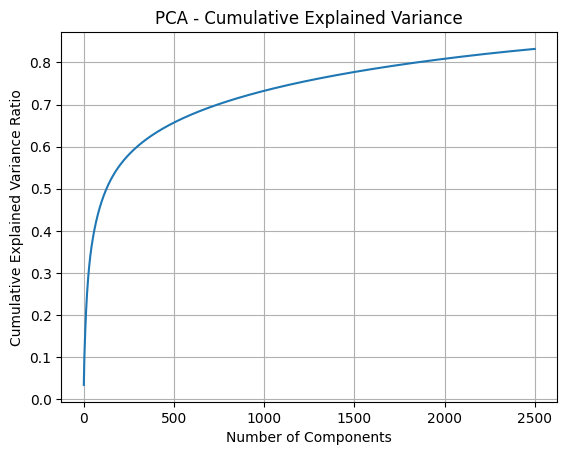

In [34]:
import matplotlib.pyplot as plt



# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance ratio
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA - Cumulative Explained Variance')
plt.grid(True)
plt.show()


In [35]:
df_embeddings['reduced_embeddings'] = list(reduced_embeddings)
df_embeddings.drop('Embedding',axis=1)


,News-ID,Title,reduced_embeddings
0,N55528,"The Brands Queen Elizabeth, Prince Charles, an...","[-6.7799583050031424, -4.88079356006585, -6.34..."
1,N19639,50 Worst Habits For Belly Fat,"[-8.645599458542549, 4.6344395559617295, -12.3..."
2,N61837,The Cost of Trump's Aid Freeze in the Trenches...,"[-4.551657935066596, -6.468450025361939, 4.447..."
3,N53526,I Was An NBA Wife. Here's How It Affected My M...,"[-2.2371205926130626, -13.195643491013033, -0...."
4,N38324,"How to Get Rid of Skin Tags, According to a De...","[-8.030029164864969, -5.113602815588137, 0.712..."
...,...,...,...
51275,NaN,Realme takes chunk of India mobile market as S...,"[-7.3524731212025864, 3.002643827014867, -8.57..."
51276,NaN,Young Northeast Florida fans flock to U.S. wom...,"[5.570521631968039, 1.1379308227287013, -5.132..."
51277,NaN,"Adapting, Learning And Soul Searching: Reflect...","[-7.373748994908752, 1.5156482795988084, -6.74..."
51279,NaN,St. Dominic soccer player tries to kick cancer...,"[-0.22468195795155038, 2.8241743631188045, 3.3..."


In [36]:
from sklearn.metrics.pairwise import cosine_similarity

#Calculates the cosine similarity beetwen 2 embeding vectors of news titles
def calculate_cosine(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    x1 = x1.reshape(1, -1)
    x2 = x2.reshape(1, -1)
    return cosine_similarity(x1, x2)[0][0]

#Given an article, creates a dataframe with all the other articles codes,titles and their similarity to the target article.
def find_cosine_closest(title,embedings):
  similarities = []
  articles_code = []
  articles_title =[]
  embeddings = []
  for ind,article_title in enumerate(embedings['reduced_embeddings']):
    similarities.append(calculate_cosine(title,article_title))
    articles_code.append(embedings['News-ID'].iloc[ind])
    articles_title.append(embedings['Title'].iloc[ind])
    embeddings.append(article_title)


  df = pd.DataFrame()
  df['ID'] = articles_code
  df['similarities'] = similarities
  df['Title'] = articles_title
  df['reduced_embeddings'] = embeddings

  return df



#Gets back the user click history, but this time the returns are the vector embedings for the codes in there in the dataset.
def user_history_embedings(user, embedings):
    history = user['User Click History'].to_list()
    click_history = user['User Click History'].values
    news = []
    for ind, item in enumerate(click_history):
        if isinstance(item, str):
            news.append(item.split(' '))

    news = np.array(news).flatten()

    user_embedings = []
    for code in news:
        embeding = embedings.loc[embedings['News-ID'] == code, 'reduced_embeddings'].values
        if len(embeding) != 0:
            user_embedings.append(embeding)

    return user_embedings


#Here we generate all of the K(K being the number of articles in the user history) recommendations for each user. This function also returns the title of each recommended article.
def generate_recommendations(user, embedings,val_size=0.5):
    user_embedings = user_history_embedings(user, embedings)
    if len(user_embedings) != 0:
        user_embedings = user_embedings[0]

    title_of_the_recommendations = []
    code_of_the_recommendations = []
    embeddings_recommendations = []

    # Get the news IDs from the user's click history
    click_history = user['User Click History'].values
    click_history_ids = [item.split(' ') for item in click_history]
    click_history_ids = [code for sublist in click_history_ids for code in sublist]



    for embeding in user_embedings:
        similarities = find_cosine_closest(embeding, embedings)

        # Filter out the news articles present in the click history
        similarities_f = similarities[~similarities['ID'].isin(click_history_ids)]

        top_k = similarities_f.sort_values(by='similarities', ascending=False)
        title_of_the_recommendations.append(top_k['Title'].iloc[:3])
        code_of_the_recommendations.append(top_k['ID'].iloc[:3])
        embeddings_recommendations.append(top_k['reduced_embeddings'].iloc[:3])

    recommendations = pd.DataFrame()
    recommendations['Titles'] = np.array(title_of_the_recommendations).flatten()
    recommendations['News-ID'] = np.array(code_of_the_recommendations).flatten()
    recommendations['reduced_embeddings'] = np.array(embeddings_recommendations).flatten()

    return recommendations

def get_user_news_ids(user):
  user = find_info(user,user_info)
  history = user['User Click History'].to_list()
  click_history = user['User Click History'].values
  news = []
  for ind, item in enumerate(click_history):
    if isinstance(item, str):
      news.append(item.split(' '))

  news = np.array(news).flatten()

  return news



def get_user_titles(user, data):
    user = find_info(user, user_info)
    history = user['User Click History'].to_list()
    news = []
    for item in history:
        news.append(item.split(' '))

    news = np.array(news).flatten()
    titles = []
    for code in news:
        matching_rows = data.loc[data['News-ID'] == code, 'Title']
        if not matching_rows.empty:
            title = matching_rows.values[0]
            titles.append(title)

    return titles






Now create embeddings for the users interest. In this part We'll use the BERT model again to get the embeddings, then we'll have each users embeddings suffer a weighted mean. This weighted mean will represent our user interest in a single vector.


In [37]:
from scipy.spatial.distance import cdist
from scipy.spatial.distance import cosine
from gensim.models import KeyedVectors
import gensim.downloader as api




import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

def get_interest(user, embeddings,user_info):
    user_ = find_info(user, user_info)

    user_embeddings = user_history_embedings(user_, embeddings)

    if len(user_embeddings) != 0:
        user_embeddings = np.array(user_embeddings[0])

        # Calculate the average of the embeddings
        user_interest = np.mean(user_embeddings, axis=0)

        # Normalize the user interest vector
        user_interest /= np.linalg.norm(user_interest)

        return user_interest
    else:
        return None


def calculate_user_similarity(user_interest1, user_interest2):
    if user_interest1 is None or user_interest2 is None:
        return 0.0

    user_interest1 = user_interest1.reshape(1, -1)
    user_interest2 = user_interest2.reshape(1, -1)
    distance = euclidean_distances(user_interest1, user_interest2)
    similarity = 1 / (1 + distance)
    return similarity[0, 0]


def find_most_similar_user(user, users_id):
    similarities = []
    user_interest = get_interest(user, df_embeddings)
    if user_interest is None:
        return None

    other_users_id = [u for u in users_id if u != user]  # Create a separate list of user IDs excluding the current user

    for u in other_users_id:
        interest_temp = get_interest(u, df_embeddings)
        if interest_temp is not None:
            similarities.append(calculate_user_similarity(user_interest, interest_temp))

    if len(similarities) == 0:
        return None

    max_similarity_index = np.argmax(np.array(similarities))
    most_similar_user = other_users_id[max_similarity_index]  # Retrieve the correct user ID from the separate list

    return most_similar_user





def click_predictor(user_interest, candidate_embeddings, threshold):

    candidate_embeddings = np.array(candidate_embeddings)
    if user_interest is not None:
    # Calculate the dot product between user interest and candidate news embeddings
      click_scores = np.dot(user_interest, candidate_embeddings.T)

    # Apply sigmoid function to convert scores into probabilities
      click_probabilities = 1 / (1 + np.exp(-click_scores))

    # Apply threshold to convert probabilities into binary click/non-click decisions
      click_decisions = (click_probabilities >= threshold).astype(int)

      return click_decisions.tolist()

Now we create the functions for calculating the metrics

In [ ]:
# evaluate the auc
from sklearn.metrics import roc_auc_score

def evaluate(click_decisions, candidate_news, user_click):
    recommended_news = candidate_news['News-ID'].to_list()
    positive_predictions = np.array(recommended_news)[np.array(click_decisions) == 1]  # Filter positive predictions
    # Calculate the AUC score
    y_true = [1 if news_id in user_click else 0 for news_id in recommended_news]

    # Check if y_true contains only one class
    unique_y_true_labels = set(y_true)
    if len(unique_y_true_labels) < 2:
        return 0.5

    y_score = [1 if news_id in positive_predictions else 0 for news_id in recommended_news]
    auc_score = roc_auc_score(y_true, y_score)

    return auc_score

# evaluate the recall 
def evaluate_r(click_decisions, candidate_news, user_click):
    recommended_news = candidate_news['News-ID'].to_list()
    positive_predictions = np.array(recommended_news)[np.array(click_decisions) == 1]  # Filter positive predictions

    true_positives = len(set(positive_predictions) & set(user_click))  # Count true positives
    false_positives = len(set(positive_predictions) - set(user_click))  # Count false positives
    false_negatives = len(set(user_click) - set(positive_predictions))  # Count false negatives

    if true_positives + false_positives > 0:
        recall = true_positives / (true_positives + false_negatives)
    else:
        recall = 0.0

    return recall
# evaluate the mrr
def evaluate_m(click_decisions, candidate_news, user_click):
    recommended_news = candidate_news['News-ID'].to_list()
    positive_predictions = np.array(recommended_news)[np.array(click_decisions) == 1]  # Filter positive predictions
    # Calculate the MRR score
    mrr_score = 0
    for i, news_id in enumerate(recommended_news):
        if news_id in user_click:
            mrr_score = 1 / (i + 1)
            break

    return mrr_score

# evaluate the NDCG@5 
def evaluate_5(click_decisions, candidate_news, user_click):
    recommended_news = candidate_news['News-ID'].to_list()
    positive_predictions = np.array(recommended_news)[np.array(click_decisions) == 1]  # Filter positive predictions
    # Calculate the NDCG@5 score
    dcg = 0
    idcg = 0
    for i, news_id in enumerate(recommended_news[:5]):
        if news_id in user_click:
            dcg += 1 / np.log2(i + 2)
        idcg += 1 / np.log2(i + 2)
    ndcg_score = dcg / idcg

    return ndcg_score
# NDCG@10
def evaluate_10(click_decisions, candidate_news, user_click):
    recommended_news = candidate_news['News-ID'].to_list()
    positive_predictions = np.array(recommended_news)[np.array(click_decisions) == 1]  # Filter positive predictions
    # Calculate the NDCG@10 score
    dcg = 0
    idcg = 0
    for i, news_id in enumerate(recommended_news[:10]):
        if news_id in user_click:
            dcg += 1 / np.log2(i + 2)
        idcg += 1 / np.log2(i + 2)
    if idcg == 0:
        ndcg_score = 0.0  # Set the NDCG score to 0 when idcg is zero
    else:
        ndcg_score = dcg / idcg

    return ndcg_score

In [38]:
# check the auc for the training set
auc = []
for u in tqdm(users_id[:2]):
  user_interest = get_interest(u,df_embeddings,user_info)
  predictions = click_predictor(user_interest,reduced_embeddings,0.05)
  user = find_info(u,user_info)
  history = user['User Click History'].to_list()
  click_history = user['User Click History'].values
  news = []
  for ind, item in enumerate(click_history):
    if isinstance(item, str):
      news.append(item.split(' '))

  news = np.array(news).flatten()
  auc.append(evaluate(predictions,df_embeddings,news))

auc_med = np.mean(np.array(auc))

  0%|          | 0/2 [00:00<?, ?it/s]/tmp/ipykernel_332823/2445061148.py:93: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/tmp/ipykernel_332823/2445061148.py:100: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

 50%|█████     | 1/2 [00:10<00:10, 10.52s/it]/tmp/ipykernel_332823/2445061148.py:93: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/tmp/ipykernel_332823/2445061148.py:100: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

100%|██████████| 2/2 [00:22<00:00, 11.26s/it]


In [39]:
auc_med

0.5035662188450968

In [40]:
user_interest = get_interest(u,df_embeddings,user_info)
predictions = click_predictor(user_interest,reduced_embeddings,0.05)
user = find_info(u,user_info)
history = user['User Click History'].to_list()
click_history = user['User Click History'].values
news = []
for ind, item in enumerate(click_history):
  if isinstance(item, str):
    news.append(item.split(' '))

news = np.array(news).flatten()

/tmp/ipykernel_332823/542345454.py:10: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/tmp/ipykernel_332823/542345454.py:11: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



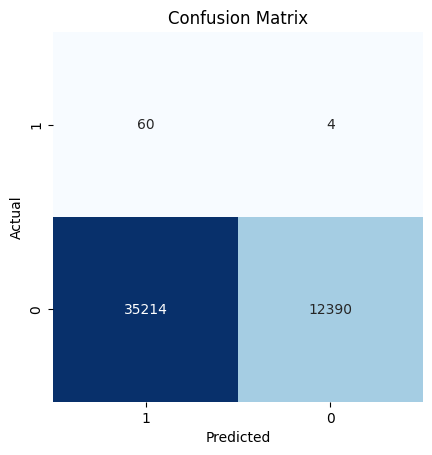

In [41]:
# check the confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

def fprint_confusion(click_decisions, candidate_news, user_click):
    recommended_news = candidate_news['News-ID'].to_list()
    positive_predictions = np.array(recommended_news)[np.array(click_decisions) == 1] # Filter positive predictions

    # Build confusion matrix using scikit-learn
    labels = [1, 0] # Positive class: 1, Negative class: 0
    y_true = [1 if news_id in user_click else 0 for news_id in recommended_news]
    y_pred = [1 if news_id in positive_predictions else 0 for news_id in recommended_news]
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Print confusion matrix using seaborn heatmap
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
    xticklabels=labels, yticklabels=labels)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title("Confusion Matrix")

    plt.show()
fprint_confusion(predictions,df_embeddings,news)

In [42]:
recall = []
for u in users_id[:2]:
  user_interest = get_interest(u,df_embeddings,user_info)
  predictions = click_predictor(user_interest,reduced_embeddings,0.05)
  user = find_info(u,user_info)
  history = user['User Click History'].to_list()
  click_history = user['User Click History'].values
  news = []
  for ind, item in enumerate(click_history):
    if isinstance(item, str):
      news.append(item.split(' '))

  news = np.array(news).flatten()
  recall.append(evaluate_r(predictions,df_embeddings,news))

recall_med = np.mean(np.array(recall))
recall_med

0.6481481481481481

In [43]:
mrr = []
for u in users_id[:2]:
  user_interest = get_interest(u,df_embeddings,user_info)
  predictions = click_predictor(user_interest,reduced_embeddings,0.05)
  user = find_info(u,user_info)
  history = user['User Click History'].to_list()
  click_history = user['User Click History'].values
  news = []
  for ind, item in enumerate(click_history):
    if isinstance(item, str):
      news.append(item.split(' '))

  news = np.array(news).flatten()
  mrr.append(evaluate_m(predictions,df_embeddings,news))

mrr_med = np.mean(np.array(mrr))
mrr_med

0.004253292806484296

In [44]:
ndcg = []
for u in users_id[:2]:
  user_interest = get_interest(u,df_embeddings,user_info)
  predictions = click_predictor(user_interest,reduced_embeddings,0.05)
  user = find_info(u,user_info)
  history = user['User Click History'].to_list()
  click_history = user['User Click History'].values
  news = []
  for ind, item in enumerate(click_history):
    if isinstance(item, str):
      news.append(item.split(' '))

  news = np.array(news).flatten()
  ndcg.append(evaluate_5(predictions,df_embeddings,news))

ndcg5_med = np.mean(np.array(ndcg))
ndcg5_med

0.0

## Now test the model on the small test set

In [46]:
#Load The validation news dataset
data_val = pd.read_csv('/home/guest/Xiangrui/Egg/MINDsmall_dev/behaviors.tsv',header=None, delimiter='\t')
data_val.columns=['News-ID',
"Category",
"SubCategory",
"Title",
"Abstract",
"URL",
"Title Entities",
"Abstract Entities "]


#Do some data cleaning
data_val.dropna(inplace=True)
print('the number of articles before processing :',len(data_val))
data_val.drop_duplicates(subset=['Title'],inplace=True)
print('The number of articles after processing :',len(data_val))
print('the number of articles before processing :',len(data_val))
data_val=data_val[data_val['Title'].apply((lambda x: len(x.split())>=4))]
print('The number of articles after processing :',len(data_val))


#Load the validation behavior dataset
user_info_val = pd.read_csv('/home/guest/Xiangrui/Egg/MINDsmall_dev/news.tsv',header=None, delimiter='\t')
user_info_val.dropna(True)


#Get the unique users in the dataset
user_info_val.columns=["Impression-ID","User-ID","Impression Time","User Click History", "Impression News"]
users_id_val= user_info_val['User-ID'].unique()


the number of articles before processing : 40393
The number of articles after processing : 39818
the number of articles before processing : 39818
The number of articles after processing : 39728


/tmp/ipykernel_332823/4006780151.py:25: FutureWarning:

In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.



In [47]:
val_news_titles = data_val['Title']

In [48]:
import torch
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer, DistilBertModel

# Load pre-trained DistilBERT model and tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertModel.from_pretrained(model_name)

# Rest of your code remains unchanged
# ...


# Set device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Tokenize news titles
tokenized_inputs = tokenizer(
    list(val_news_titles), padding=True, truncation=True, return_tensors='pt')
input_ids = tokenized_inputs['input_ids']
attention_mask = tokenized_inputs['attention_mask']
num_samples = len(val_news_titles)
batch_size = 1

# Embed news titles
with torch.no_grad():
    model.to(device)
    model.eval()

    # Embed news titles in batches
    embeddings = []
    for i in range(0, num_samples, batch_size):
        inputs_batch = {
            'input_ids': input_ids[i:i+batch_size].to(device),
            'attention_mask': attention_mask[i:i+batch_size].to(device)
        }

        # Get the BERT embeddings
        outputs = model(**inputs_batch)

        # Extract the last layer's hidden states
        batch_embeddings =  outputs.last_hidden_state.cpu().numpy()
        embeddings.append(batch_embeddings)

# Concatenate embeddings from all batches
embeddings = np.concatenate(embeddings, axis=0)

# Create a DataFrame to store embeddings and titles
df_embeddings_val = pd.DataFrame(
    {'News-ID': data_val['News-ID'].loc[:num_samples], 'Title': val_news_titles[:num_samples], 'Embedding': embeddings.tolist()})

# Print the DataFrame
print(df_embeddings_val)



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


      News-ID                                              Title  \
0      N55528  The Brands Queen Elizabeth, Prince Charles, an...   
2      N61837  The Cost of Trump's Aid Freeze in the Trenches...   
3      N53526  I Was An NBA Wife. Here's How It Affected My M...   
4      N38324  How to Get Rid of Skin Tags, According to a De...   
5       N2073  Should NFL be able to fine players for critici...   
...       ...                                                ...   
42409     NaN  Roman Polanski Denies Rape Allegation by Valen...   
42410     NaN  Marvel's Kevin Feige Breaks Silence on Scorses...   
42411     NaN  Why Kate & Meghan Were on Different Balconies ...   
42412     NaN           See the stars at the 2019 Baby2Baby gala   
42413     NaN  Tennessee judge holds lawyer's baby as he swea...   

                                               Embedding  
0      [[-0.0063010589219629765, 0.10075036436319351,...  
2      [[-0.1918281763792038, -0.1264750361442566, -0...  
3     

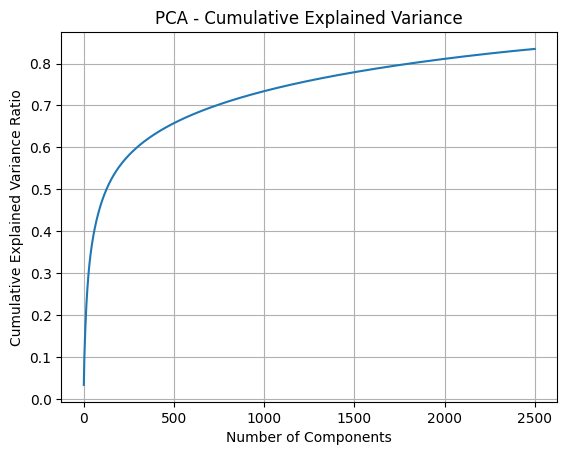

In [49]:
#Lets flatten the embeddings to get one vector for each tittle

from sklearn.decomposition import PCA

# Assuming your DataFrame is called 'df_embeddings' with an 'Embedding' column

# Extract the embeddings as a NumPy array
embeddings = np.array(df_embeddings_val['Embedding'].tolist())

# Reshape the embeddings array
reshaped_embeddings = embeddings.reshape(embeddings.shape[0], -1)

# Apply PCA to reduce dimensionality to have .85 explained variance
pca = PCA(n_components=n_components)
reduced_embeddings_val = pca.fit_transform(reshaped_embeddings)

# 'reduced_embeddings' will have shape (length of news titles, n_components)
import matplotlib.pyplot as plt
# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance ratio
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA - Cumulative Explained Variance')
plt.grid(True)
plt.show()


In [50]:
df_embeddings_val['reduced_embeddings'] = list(reduced_embeddings_val)
df_embeddings_val.drop('Embedding',axis=1)


,News-ID,Title,reduced_embeddings
0,N55528,"The Brands Queen Elizabeth, Prince Charles, an...","[-6.863063555316587, -5.185045577830645, -5.72..."
2,N61837,The Cost of Trump's Aid Freeze in the Trenches...,"[-4.133304525914735, -5.780119417734531, 5.142..."
3,N53526,I Was An NBA Wife. Here's How It Affected My M...,"[-2.7975078168058047, -12.860580673325295, 0.7..."
4,N38324,"How to Get Rid of Skin Tags, According to a De...","[-8.024261463968552, -4.197566711019205, 0.883..."
5,N2073,Should NFL be able to fine players for critici...,"[7.372305590752162, -0.8611150888594575, 0.630..."
...,...,...,...
42409,NaN,Roman Polanski Denies Rape Allegation by Valen...,"[-3.590350082627448, 0.24007500888391056, 8.24..."
42410,NaN,Marvel's Kevin Feige Breaks Silence on Scorses...,"[4.045678688198598, -14.34867787878042, 4.3441..."
42411,NaN,Why Kate & Meghan Were on Different Balconies ...,"[-2.176647648874411, -4.2863345385692755, -2.4..."
42412,NaN,See the stars at the 2019 Baby2Baby gala,"[-3.3070624718288615, -0.4893186357102414, -15..."


In [68]:

k=0.72
auc_val = []

for u in tqdm(users_id_val[:100]):
  user_interest = get_interest(u,df_embeddings_val,user_info_val)
  predictions = click_predictor(user_interest,reduced_embeddings_val,k)
  user = find_info(u,user_info_val)
  history = user['User Click History'].to_list()
  click_history = user['User Click History'].values
  news = []
  for ind, item in enumerate(click_history):
    if isinstance(item, str):
      news.append(item.split(' '))

  news = np.array(news).flatten()
  auc_val.append(evaluate(predictions,df_embeddings_val,news))

auc_med_test = np.mean(np.array(auc_val))

print("The best values:")    
print(auc_med_test)
print(k)



/tmp/ipykernel_332823/2445061148.py:93: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/tmp/ipykernel_332823/2445061148.py:100: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/tmp/ipykernel_332823/2445061148.py:93: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/tmp/ipykernel_332823/2445061148.py:100: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/tmp/ipykernel_332823/2445061148.py:93: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/tmp/ipykernel_332823/2445061148.py:100: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise c

The best values:
0.5881025149641931
0.72


In [69]:
print("The best values:")    
print(auc_med_test)
print(k)


The best values:
0.5881025149641931
0.72


The mean auc for the test is .588

In [63]:
user_interest = get_interest(u,df_embeddings,user_info_val)
predictions = click_predictor(user_interest,reduced_embeddings_val,k)
user = find_info(u,user_info_val)
history = user['User Click History'].to_list()
click_history = user['User Click History'].values
news = []
for ind, item in tqdm(enumerate(click_history)):
  if isinstance(item, str):
    news.append(item.split(' '))

news = np.array(news).flatten()

1it [00:00, 31068.92it/s]


In [64]:
# fprint_confusion(predictions,df_embeddings,news)

In [70]:
from tqdm import tqdm

In [71]:
recall_val = []
for u in tqdm(users_id[:100]):
  user_interest = get_interest(u,df_embeddings,user_info)
  predictions = click_predictor(user_interest,reduced_embeddings,k)
  user = find_info(u,user_info)
  history = user['User Click History'].to_list()
  click_history = user['User Click History'].values
  news = []
  for ind, item in enumerate(click_history):
    if isinstance(item, str):
      news.append(item.split(' '))

  news = np.array(news).flatten()
  recall.append(evaluate_r(predictions,df_embeddings,news))

recall_test = np.mean(np.array(recall))
recall_test

100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


0.49929621388469936

In [72]:
mrr_val = []
for u in tqdm(users_id[:100]):
  user_interest = get_interest(u,df_embeddings,user_info)
  predictions = click_predictor(user_interest,reduced_embeddings,k)
  user = find_info(u,user_info)
  history = user['User Click History'].to_list()
  click_history = user['User Click History'].values
  news = []
  for ind, item in enumerate(click_history):
    if isinstance(item, str):
      news.append(item.split(' '))

  news = np.array(news).flatten()
  mrr_val.append(evaluate_m(predictions,df_embeddings,news))

mrr_test = np.mean(np.array(mrr_val))
mrr_test

 28%|██▊       | 28/100 [00:27<01:02,  1.16it/s]/tmp/ipykernel_332823/2445061148.py:127: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


0.008051354175564969

In [73]:
ndcg2 = []
for u in tqdm(users_id[:100]):
  user_interest = get_interest(u,df_embeddings,user_info)
  predictions = click_predictor(user_interest,reduced_embeddings,k)
  user = find_info(u,user_info)
  history = user['User Click History'].to_list()
  click_history = user['User Click History'].values
  news = []
  for ind, item in enumerate(click_history):
    if isinstance(item, str):
      news.append(item.split(' '))

  news = np.array(news).flatten()
  ndcg2.append(evaluate_5(predictions,df_embeddings,news))

ndcg5_test = np.mean(np.array(ndcg2))
ndcg5_test

 28%|██▊       | 28/100 [00:27<01:01,  1.17it/s]/tmp/ipykernel_332823/2445061148.py:141: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


0.002921366996854129